# Classify single image patches

Not expected to be very precise - more of a model structure search

In [67]:
import os
import numpy as np
import pandas as pd

import skelm

from matplotlib import pyplot as plt
import seaborn as sn
%matplotlib inline

In [68]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# 

## Load data

In [70]:
overlap = '10p'
samples = 200
data_file = "/Users/akusok/wrkdir/research-signatures-data/MCYTD_overlap{}_n{}.pkl".format(overlap, samples)

X = pd.read_pickle(data_file)

In [70]:
# X = X.sample(frac=1).reset_index(drop=True)
X = X.sample(100000).reset_index(drop=True)

uid = pd.get_dummies(X.uid, prefix='user')
sig_true = X.sig_true
fid = X.fid
X = X.loc[:, '0':'1023']

X = X - X.mean()
X = X / X.std().clip(lower=0.5)
X = X.clip(lower=-5, upper=5)
X = pd.concat((X, uid), axis=1)

x = np.array(X)
y = np.array(sig_true)
groups = fid

#  

## Run ELM

In [80]:
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
import scipy
from sklearn.utils.fixes import loguniform
from time import time

In [13]:
params = {
    'alpha': loguniform(1e-2, 1e+1),
#     'ufunc': ['tanh', 'sigm', 'relu', 'lin'],
#     'pairwise_metric': [None, 'euclidean', 'cityblock', 'cosine'],
#     'density': loguniform(0.001, 1),
    'n_neurons': loguniform(1000, 10000),
}

In [ ]:
for i in range(2, 100000):
    rcv = RandomizedSearchCV(skelm.ELMClassifier(), params, n_iter=100, scoring='accuracy', cv=3, refit=False)
    res = rcv.fit(x, y)
    pd.DataFrame(res.cv_results_).to_pickle("res_v3/res_{}_{}.pkl".format(overlap, i))

## 

## Check results

In [ ]:
raise IOError

In [60]:
fname0 = "res_v2/res_v2_{}_n100000.pkl"
Z = pd.concat((pd.read_pickle(fname0.format(i)) for i in range(9999) if os.path.isfile(fname0.format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

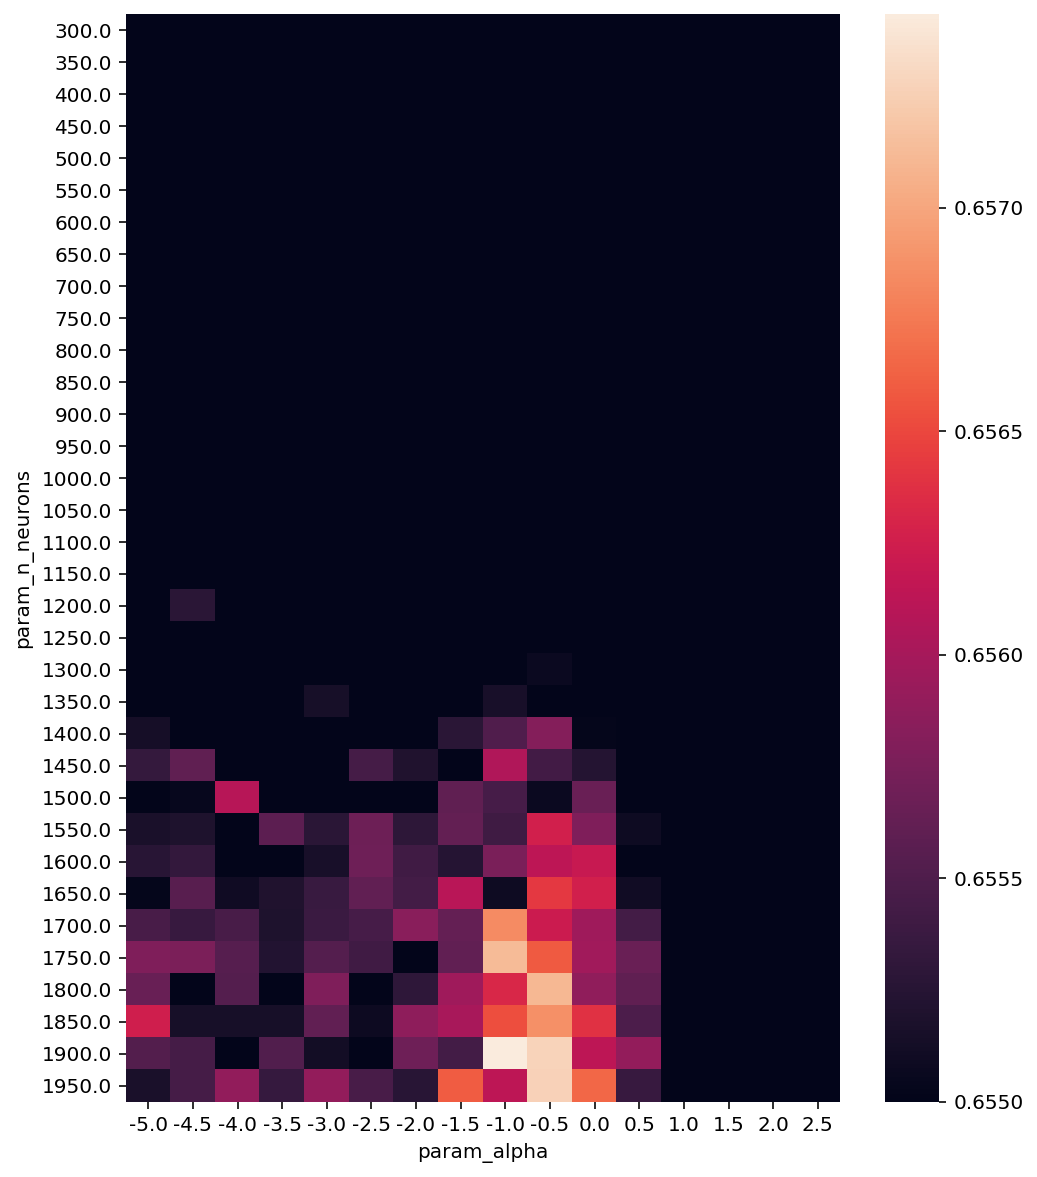

In [66]:
plt.figure(figsize=(8, 10))
P = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
sn.heatmap(P, vmin=0.655)